In [23]:
import random

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from himalaya.backend import set_backend
from himalaya.ridge import RidgeCV
from scipy.stats import zscore

In [24]:
np.random.seed(42)
backend = set_backend("cupy")
plt.style.use("default")
sns.set_theme(style="whitegrid")

In [25]:
n_samples_train = 1000
n_samples_test = 100
n_targets = 10000
d_list = [100, 100, 100]
scalars = [0.6, 0.3, 0.1]
noise_scalar = 0.1
hidden_feature_space_names = ["A", "B", "C"]
researcher_feature_space_names = [r"$X_1$", r"$X_2$"]

In [26]:
feature_spaces = []
# Generate a random matrix of shape (samples, total rank)
M = np.random.randn(n_samples_train + n_samples_test, sum(d_list))
M = zscore(M, axis=0)
M

array([[ 0.47184223, -0.12471972,  0.67046674, ...,  0.29841288,
         0.85108902,  0.6857001 ],
       [-0.8779542 , -0.54591604,  0.77395921, ..., -0.99906232,
        -0.42079477,  0.42996468],
       [ 0.73684571, -0.90728224,  0.90104514, ...,  0.13640207,
         1.2493477 , -0.78039671],
       ...,
       [ 1.86417759,  1.13467061, -0.05470728, ..., -0.16307591,
         0.07761028, -0.87354415],
       [ 0.01080282,  0.25354499, -0.05047578, ..., -0.22748839,
        -1.85091248, -1.35096737],
       [ 0.37236962, -0.14983556, -1.36164894, ...,  1.41518184,
        -1.04903332,  0.80812089]], shape=(1100, 300))

<Axes: ylabel='Count'>

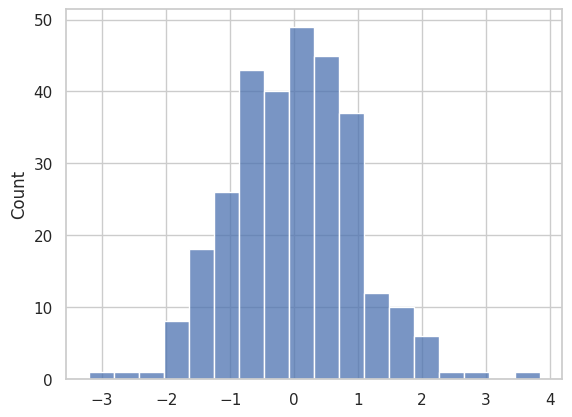

In [27]:
sns.histplot(M[0])

In [28]:
U, S, Vt = np.linalg.svd(M, full_matrices=False)
print(U.shape, S.shape, Vt.shape)
S

(1100, 300) (300,) (300, 300)


array([49.52930877, 49.33874483, 49.04435523, 48.85777223, 48.59780425,
       48.30515054, 48.19762784, 47.74391064, 47.60567271, 47.38248951,
       47.31040164, 47.11333295, 47.05581164, 46.68165859, 46.64153538,
       46.38825538, 46.26812595, 46.17372817, 46.04514253, 45.97483656,
       45.87268864, 45.52702211, 45.46839537, 45.41403153, 45.20645979,
       45.08751567, 44.85957684, 44.80951133, 44.58420962, 44.43933553,
       44.23903519, 44.01973682, 43.98154209, 43.8047093 , 43.72351628,
       43.6650697 , 43.41469849, 43.3676072 , 43.20071775, 43.06050945,
       42.96427738, 42.81398941, 42.70658611, 42.5952928 , 42.49772557,
       42.30831257, 42.1582332 , 42.06899774, 41.85127067, 41.82007078,
       41.6468681 , 41.54589739, 41.45860085, 41.36700383, 41.27945445,
       41.17303134, 41.06842525, 40.83426998, 40.80704864, 40.68091463,
       40.64214108, 40.37243718, 40.35832869, 40.19889136, 40.10231246,
       40.00669827, 39.76371036, 39.70237691, 39.63288849, 39.46

Text(17.31944444444445, 0.5, 'value')

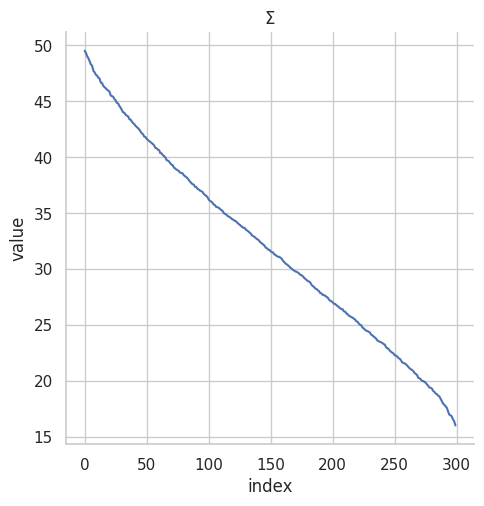

In [29]:
sns.relplot(S, kind="line")
plt.title(r"$\Sigma$")
plt.xlabel("index")
plt.ylabel("value")

Shuffle U, S and V indices to remove singular value order

In [30]:
index_shuffle = list(range(U.shape[1]))
random.shuffle(index_shuffle)
U = U[:, index_shuffle]
S = S[index_shuffle]
Vt = Vt[index_shuffle, :]

Text(17.31944444444445, 0.5, 'value')

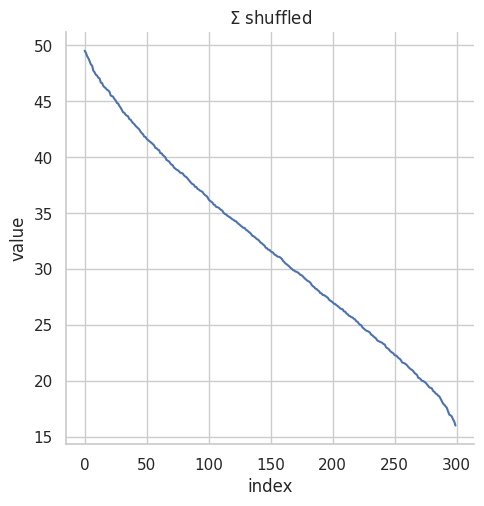

In [31]:
sns.relplot(S, kind="line")
plt.title(r"$\Sigma$ shuffled")
plt.xlabel("index")
plt.ylabel("value")

Split up S to create three orthogonal matrices to be used as feature spaces

In [32]:
start = 0
for rank in d_list:
    _S = np.zeros(len(S))
    _S[start:start + rank] = S[start:start + rank]

    diag_S = np.diag(_S)

    space = U @ diag_S @ Vt
    feature_spaces.append(space)
    start += rank
feature_spaces

[array([[ 0.62387201, -0.19201897, -0.50698236, ..., -0.3026311 ,
          0.26794973, -0.70092173],
        [-0.7931896 , -0.9844012 ,  0.38516298, ..., -0.89969435,
         -0.39987342,  0.84515327],
        [ 0.51758114, -0.27449713,  0.46322117, ..., -1.06503973,
          0.91667922, -0.26800308],
        ...,
        [ 1.15741067,  0.91197783,  0.78201545, ...,  0.08819521,
         -0.22818494, -0.00910975],
        [ 0.51875936,  0.19224232, -0.41250576, ..., -0.78751879,
         -1.52213531, -0.18616604],
        [-0.57606636,  0.14227695, -1.30132398, ...,  2.22496257,
         -0.53469463,  0.10991474]], shape=(1100, 300)),
 array([[-0.40127655,  0.64144469,  0.71254968, ...,  0.62148067,
          0.53888718,  1.25897729],
        [ 0.48855689,  0.22130689,  0.04540548, ...,  0.13219577,
          0.26037445,  0.39703714],
        [-0.25568022, -0.63330871,  0.01538327, ...,  1.10300298,
          0.69556345, -0.47578369],
        ...,
        [ 0.99575088,  0.09710742, 

Text(0.5, 0, 'value')

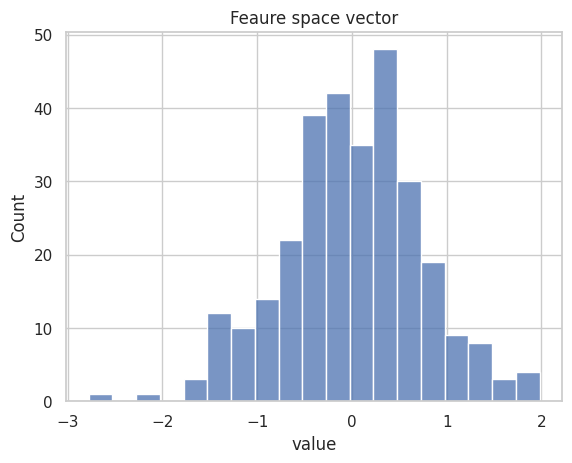

In [33]:
sns.histplot(feature_spaces[0][0])
plt.title("Feaure space vector")
plt.xlabel("value")

make sure that all feature spaces are orthogonal to each other (histograms should be nearly 0)

In [34]:
import pandas as pd

matmuls_df = pd.DataFrame()

for i in range(len(feature_spaces)):
    for j in range(i + 1, len(feature_spaces)):
        first_transposed = feature_spaces[i].T @ feature_spaces[
            j]
        matmuls_df = pd.concat([
            matmuls_df,
            pd.DataFrame(
                {'Features': [f"{hidden_feature_space_names[i]}.T x {hidden_feature_space_names[j]}"],
                 'Values (avg across samples)': [first_transposed.mean(axis=0)]}), ], ignore_index=True)

for i in range(len(feature_spaces)):
    for j in range(i + 1, len(feature_spaces)):
        second_transposed = feature_spaces[i] @ feature_spaces[j].T
        matmuls_df = pd.concat([
            matmuls_df,
            pd.DataFrame(
                {'Features': [f"{hidden_feature_space_names[i]} x {hidden_feature_space_names[j]}.T"],
                 'Values (avg across samples)': [second_transposed.mean(axis=0)], }),
        ], ignore_index=True)
matmuls_df

,Features,Values (avg across samples)
0,A.T x B,"[-1.8074199544434086e-15, 5.134550192427886e-16, -1.0073307928533854e-15, 1.9215184998699898e-15, 8.089709457870242e-16, 1.7310227325613898e-16, 1.4598652148256618e-15, 5.257062146712954e-15, 2.5087686557808317e-15, -1.4289958105706546e-15, 1.7640056082512956e-15, 1.2611439670351388e-15, 1.1627735811240805e-15, -5.837344496661956e-15, 2.0264692701665866e-15, 7.962785523544605e-16, 8.588283440894943e-16, -4.2785451107955435e-15, -2.603542381685031e-15, -2.5213613026135267e-15, -8.293250345718187e-16, 7.747246131654488e-16, -1.979770514193291e-15, 3.22367132987722e-15, -1.8548357294534412e-15, -8.759197071365558e-17, -1.1287975762441782e-15, -2.906887693517509e-15, -1.0116314614709114e-15, -6.558649745987596e-16, -1.473670722488644e-15, -8.777209283457784e-16, 4.3517273118354185e-16, 7.490963867725261e-15, -8.801524324179392e-16, 2.072821081444687e-15, 4.86071830933336e-15, -3.651315361175023e-15, 1.146883514084133e-15, 3.26980340951503e-15, -2.2818783899462385e-15, 2.6869016271173035e-15, -4.438382531872046e-15, 5.854153967144171e-15, 1.534247266269754e-15, 7.440113340232794e-16, 3.8343171230674026e-16, 7.699859268702387e-17, -5.772003245733496e-16, -1.6210499378018403e-15, -1.0682716285644508e-15, 1.181876500601827e-15, -5.1629996574339054e-15, -4.537446807173495e-15, 4.384721752348497e-15, -1.8408885527065878e-15, 1.8804575951936186e-15, -1.0693991988238357e-15, -3.541403281737132e-15, -6.385141258317498e-16, -7.392466268759297e-16, -8.569302674861964e-16, -5.865649401378311e-16, -6.395578511231293e-16, 2.402563102169945e-15, -1.3587799866747e-16, 4.8367791253648796e-15, -1.0918349557798023e-15, -1.1484447652125121e-15, -2.9671303030294934e-15, -2.636893886113582e-15, -1.4644072991269278e-15, -2.3752065129537907e-15, -3.2242727006822256e-16, -2.437749076674341e-16, -1.2813824075882015e-17, 1.2832183232669437e-15, 4.894811408047891e-16, 2.6275046952998576e-15, 9.348077867343818e-16, 3.745152336402195e-16, 9.942423042271405e-16, -3.858025010572419e-15, -3.4648210226843425e-16, 2.1799691681441877e-16, 7.9109172916129e-16, -2.566696855055284e-16, 3.6617005723845374e-15, -1.5030800678180374e-16, 1.8877260865579614e-16, 4.613207963780989e-17, 2.3225287433999614e-15, -2.6437648366813467e-15, -1.928162490782981e-15, -2.7921964509033023e-15, -1.995822488757663e-15, 4.558882206924982e-16, 2.3417147850442652e-15, 1.282504195436e-15, 6.7957560874927955e-15, ...]"
1,A.T x C,"[5.248348052451964e-16, -2.1755282760456868e-15, 1.2586690948760786e-15, 2.2719095123709584e-16, 1.4204841007151951e-15, 6.752411130239721e-17, 1.5962405008895785e-15, -1.0907478624015235e-15, -1.9172163856495671e-16, 7.489842079877462e-16, -7.936677935231155e-16, 1.6751068125190708e-16, 2.0274522801363067e-15, -7.617517727709355e-16, -6.61866395024191e-16, -7.874488098617386e-17, -2.0437875928684218e-15, -1.663050484361032e-15, 1.9505462060346684e-15, -3.1203627644712147e-15, 4.015190957495918e-16, 7.463589931274347e-16, -3.126184930137462e-15, -1.2552806016863372e-15, -8.355584742621621e-16, 7.058686498443341e-16, -9.707469203479313e-16, 1.7381004043433754e-15, 9.649240318802357e-16, 8.300883129012485e-16, -6.941091220310132e-16, 1.1457501614131616e-15, -1.8327259559506685e-15, -9.870128441410071e-16, 8.1381226988789615e-16, -5.403779275899486e-16, 7.598609241821208e-16, 4.756380474664941e-16, -3.304584615208365e-15, 3.0687258290029718e-15, 3.090120751873352e-16, 6.83431899036376e-16, 5.764983398067377e-15, -2.6294721608421943e-15, 1.5692568772207594e-15, -7.420684437301853e-16, 1.5890298336411016e-15, -1.5977497103136783e-15, -6.891709425360659e-16, 1.6682257427310295e-18, -1.6228916358921689e-15, -1.0515720239023808e-15, -2.505163322156593e-15, 9.181009540578284e-16, 7.72067595041411e-17, -6.123111277271202e-16, -1.3907162458674332e-15, -1.255916666960862e-15, 8.097747009975602e-16, 3.0475679850076412e-15, 8.005806665748831e-16, -3.8457084738929836e-16, 9.197503869629032e-17, -9.892202797641877e-16, -3.4130568741611

Text(0.5, 1.02, 'Feature space matrix multiplications')

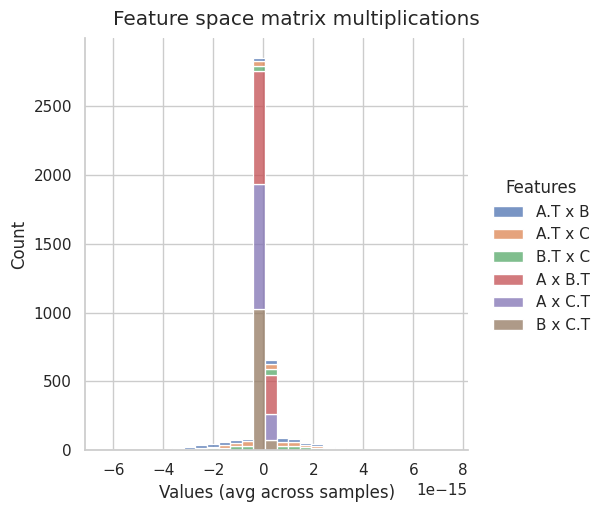

In [35]:
sns.displot(data=matmuls_df.explode("Values (avg across samples)"), x="Values (avg across samples)", multiple="stack",
            hue="Features", bins=30)
plt.suptitle("Feature space matrix multiplications", y=1.02)

split feature spaces into train and test samples

In [36]:
feature_spaces_train = [feature_space[:n_samples_train] for feature_space in feature_spaces]
feature_spaces_test = [feature_space[n_samples_train:] for feature_space in feature_spaces]

generate weights

In [37]:
betas = [np.random.randn(sum(d_list), n_targets) for _ in d_list]
betas = [zscore(beta) for beta in betas]
betas

[array([[-0.38460629, -0.16970626, -0.43662699, ...,  0.76389093,
         -0.54724117,  2.90284843],
        [-0.09814713, -0.20278397,  0.5237513 , ...,  0.93230933,
          1.28752009,  0.04879971],
        [ 0.47496226, -0.72079155, -0.59932401, ..., -0.25245321,
         -0.37423414, -0.61704289],
        ...,
        [ 1.39478625,  0.53454755,  0.11210573, ...,  0.33811356,
          0.07469666,  0.29992802],
        [-0.61751344,  0.74781886,  0.45996191, ...,  2.27891114,
          0.04883194,  0.07789179],
        [-0.98042467, -0.2961056 , -0.67027179, ..., -0.92429298,
          0.47219762,  0.44713567]], shape=(300, 10000)),
 array([[-1.40169847,  2.67279918,  2.03973585, ..., -0.03094923,
         -0.58427223, -0.49388827],
        [-0.66347222,  1.0093984 ,  0.65018904, ..., -0.88144256,
         -1.113028  ,  0.78376731],
        [-1.5680825 , -0.47965058,  1.07959107, ..., -1.27468081,
         -0.45572124,  0.11798338],
        ...,
        [ 1.07480511, -1.37367909,

create targets

In [38]:
Y_train = sum(
    [alpha * zscore(feature_space @ beta) for alpha, feature_space, beta in
     zip(scalars, feature_spaces_train, betas)])
Y_test = sum(
    [alpha * zscore(feature_space @ beta) for alpha, feature_space, beta in
     zip(scalars, feature_spaces_test, betas)])
Y_train = zscore(Y_train)
Y_test = zscore(Y_test)

add noise

In [39]:
noise_train = zscore(np.random.randn(n_samples_train, n_targets))
noise_test = zscore(np.random.randn(n_samples_test, n_targets))
Y_train += noise_train * noise_scalar
Y_test += noise_test * noise_scalar
(noise_train * noise_scalar)

array([[-0.00063417,  0.01154315, -0.03187855, ...,  0.08611207,
        -0.12916102,  0.08738936],
       [ 0.03938965,  0.00242483, -0.02673386, ...,  0.11971031,
        -0.16322497,  0.09760446],
       [ 0.08482156, -0.09030948,  0.05056161, ..., -0.02505592,
         0.01699247, -0.00441444],
       ...,
       [ 0.15958723,  0.01918551,  0.11944391, ..., -0.06331546,
        -0.02140708,  0.12214556],
       [-0.03527165,  0.07056346, -0.27609341, ...,  0.1827738 ,
         0.00448845, -0.07623852],
       [ 0.19636524,  0.04896127,  0.02460273, ...,  0.02527466,
         0.09929174, -0.21056221]], shape=(1000, 10000))

train simple linear models to confirm feature spaces predict the target

In [40]:
scores = pd.DataFrame()

linear_models = [RidgeCV() for _ in range(len(feature_spaces_train))]
for i, model in enumerate(linear_models):
    model.fit(feature_spaces_train[i], Y_train)
    score = model.score(feature_spaces_test[i], Y_test)
    scores = pd.concat([
        scores,
        pd.DataFrame({'feature space': [hidden_feature_space_names[i]], 'Score': [backend.to_numpy(score).mean()],
                      'EV': [scalars[i]]})], ignore_index=True
    )
scores

,feature space,Score,EV
0,A,0.715642,0.6
1,B,0.008142,0.3
2,C,-0.190570,0.1


Text(0.5, 1.0, 'Hidden feature space scores')

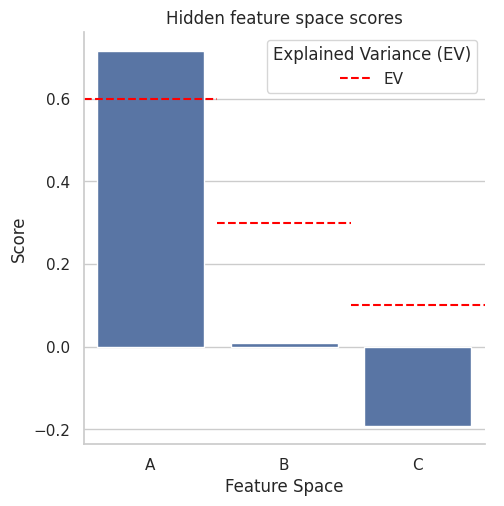

In [41]:
plot = sns.catplot(scores, x="feature space", y="Score", kind="bar").set_axis_labels("Feature Space", "Score")
for index, row in scores.iterrows():
    plot.ax.axhline(row["EV"], color='red', linestyle="--", linewidth=1.5,
                    xmin=index / 3, xmax=(index + 1) / 3,
                    label=f'EV' if index == 0 else None)
plot.ax.legend(title="Explained Variance (EV)")
plt.title("Hidden feature space scores")

Create researcher feature spaces

In [42]:
Xs_train = [1 / 2 * (feature_spaces_train[0] + feature_space) for feature_space in feature_spaces_train[1:]]
Xs_test = [1 / 2 * (feature_spaces_test[0] + feature_space) for feature_space in feature_spaces_test[1:]]

Xs_train = [zscore(x) for x in Xs_train]
Xs_test = [zscore(x) for x in Xs_test]

now train on researcher side feature spaces

In [43]:
researcher_scores = pd.DataFrame()

linear_models = [RidgeCV() for _ in range(len(Xs_train))]
for i, model in enumerate(linear_models):
    model.fit(Xs_train[i], Y_train)
    score = model.score(Xs_test[i], Y_test)
    researcher_scores = pd.concat([
        researcher_scores,
        pd.DataFrame({'feature space': [researcher_feature_space_names[i]], 'Score': [backend.to_numpy(score).mean()],
                      'EV': scalars[0] + scalars[i + 1]})],
        ignore_index=True
    )
researcher_scores

,feature space,Score,EV
0,$X_1$,0.944476,0.9
1,$X_2$,0.688195,0.7


Text(0.5, 1.0, 'Researcher side feature space scores')

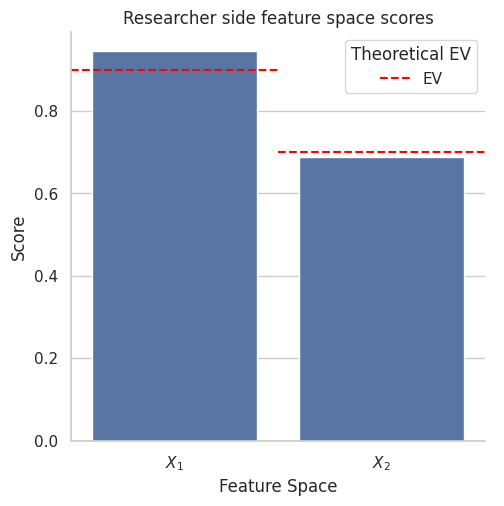

In [44]:
plot = sns.catplot(researcher_scores, x="feature space", y="Score", kind="bar").set_axis_labels("Feature Space",
                                                                                                "Score")
for index, row in researcher_scores.iterrows():
    plot.ax.axhline(row["EV"], color='red', linestyle="--", linewidth=1.5,
                    xmin=index / 2, xmax=(index + 1) / 2,
                    label=f'EV' if index == 0 else None)
plot.ax.legend(title="Theoretical EV")
plt.title("Researcher side feature space scores")